In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os, sys, re
import numpy as np
import random

from collections import defaultdict
from transformers import AutoTokenizer
from datasets import load_dataset
from grader import solution_eq_ans, extract_boxed_answer
from tqdm import tqdm

from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#44BB99', '#AAAA00',
          '#DDDDDD']
palette = sns.set_palette(COLORS)

/home/myang4/miniconda3/envs/vllm3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = "/home/myang4/mrt-analysis/outputs/regret"
folders = ["base", "mrt", "grpo"]

### Load data

In [3]:
for folder in folders:
    data = {}
    for i in range(0, 15, 5):
        with open(os.path.join(output_dir, folder, f'pass_at_k_given_prefix/pass_at_k_given_prefix_{i}_{i+5}.pkl'), 'rb') as f:
            data |= pickle.load(f)
    
    with open(os.path.join(output_dir, folder, f'pass_at_k_given_prefix/pass_at_k_given_prefix.pkl'), "wb") as f:
        pickle.dump(data, f)

    data = {}
    for i in range(0, 15, 5):
        with open(os.path.join(output_dir, folder, f'pass_at_k/extrapolate_{i}_{i+5}.pkl'), 'rb') as f:
            data |= pickle.load(f)
    
    with open(os.path.join(output_dir, folder, f'pass_at_k/extrapolate.pkl'), "wb") as f:
        pickle.dump(data, f)

INFO 04-28 17:28:24 __init__.py:183] Automatically detected platform cuda.


2025-04-28 17:28:25,037	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Load dataset and tokenizer

In [4]:
math_dataset = load_dataset("hf-cmu-collab/math_reasoning_benchmark", split="AIME2025")
tokenizer = AutoTokenizer.from_pretrained("agentica-org/DeepScaleR-1.5B-Preview")

### Compute Pass@1

In [5]:
def calculate_pass_at_1(folder):
    with open(os.path.join(output_dir, folder, f'pass_at_k_given_prefix/pass_at_k_given_prefix.pkl'), "rb") as f:
        rollouts = pickle.load(f)


    pass_at_1 = defaultdict(list)

    for n, k_completions in tqdm(rollouts.items(), total=len(rollouts)):

        answer = str(math_dataset[n]['answer'])

        for c, completions in enumerate(k_completions):
            for prefix in completions:

                answers_dict = defaultdict(list)
                answers_dict[answer] = []

                total, correct = 0, 0
                
                for r, rollout in enumerate(prefix.outputs):

                    correct += solution_eq_ans(prefix.prompt + rollout.text, str(answer))
                    total += 1

                pass_at_1[n * len(k_completions) + c].append(correct / total)
            

    with open(os.path.join(output_dir, folder, f'plot/pass@1.pkl'), "wb") as f:
        pickle.dump(pass_at_1, f)

In [6]:
for folder in folders:
    calculate_pass_at_1(folder)

100%|██████████| 15/15 [00:00<00:00, 27.86it/s]


### Compute FLOPs

In [7]:
def calculate_flops(folder):
    with open(os.path.join(output_dir, folder, f'pass_at_k_given_prefix/pass_at_k_given_prefix.pkl'), "rb") as f:
        rollouts = pickle.load(f)

    problem_to_meta_step_to_pass_at_k_flops = defaultdict(list)

    for n, k_completions in tqdm(rollouts.items(), total=len(rollouts)):

        for c, completions in enumerate(k_completions):
            for prefix in completions:
            
                base_flops = len(tokenizer.encode(prefix.prompt))
                flops = 0
                for r, rollout in enumerate(prefix.outputs):
                    flops += len(tokenizer.encode(rollout.text))

                problem_to_meta_step_to_pass_at_k_flops[n * len(k_completions) + c].append(base_flops + flops / 16)
            
            problem_to_meta_step_to_pass_at_k_flops[n * len(k_completions) + c] = np.array(problem_to_meta_step_to_pass_at_k_flops[n * len(k_completions) + c])

    with open(os.path.join(output_dir, folder, f'plot/flops.pkl'), "wb") as f:
        pickle.dump(problem_to_meta_step_to_pass_at_k_flops, f)

In [8]:
for folder in folders:
    calculate_flops(folder)

100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


## Graphs

In [9]:
folder_to_pass_at_1 = {}
folder_to_flops = {}
folder_to_extrapolate = {}

for folder in folders:
    with open(os.path.join(output_dir, folder, f'plot/pass@1.pkl'), "rb") as f:
        folder_to_pass_at_1[folder] = pickle.load(f)

    with open(os.path.join(output_dir, folder, f'plot/flops.pkl'), "rb") as f:
        folder_to_flops[folder] = pickle.load(f)

    with open(os.path.join(output_dir, folder, f'pass_at_k/extrapolate.pkl'), "rb") as f:
        folder_to_extrapolate[folder] = pickle.load(f)

In [10]:
folder_to_areas = {}

for folder in folders:
    pass_at_1 = folder_to_pass_at_1[folder]
    flops = folder_to_flops[folder]

    # cutoff areas
    areas_by_cutoff = []
    for cutoff in tqdm([4096, 8192, 12288, 16384]):

        all_problems_area = 0
        for n in range(15):
            
            areas = []
            for t in range(16):
                y = [0] + list(pass_at_1[n * 16 + t])
                x = np.array([0] + list(flops[n * 16 + t]))

                filtered_x = list(x[x < cutoff])
                
                if len(filtered_x) == len(x):
                    areas.append(np.trapz(y + [y[-1]], list(x) + [cutoff]) / cutoff)
                
                else:
                    # find next interpolate y
                    cutoff_index = len(filtered_x) - 1
                    interpolate_y = y[cutoff_index] + (cutoff - x[cutoff_index]) / (x[cutoff_index + 1] - x[cutoff_index]) * (y[cutoff_index + 1] - y[cutoff_index])
                    
                    # add interpolate x and interpolate y
                    final_x = list(x[x < cutoff]) + [cutoff]
                    final_y = y[:cutoff_index + 1] + [interpolate_y]

                    areas.append(np.trapz(final_y, final_x) / cutoff)
            

            all_problems_area += np.mean(areas)
        
        areas_by_cutoff.append(all_problems_area / 15)



    # extrapolate areas
    areas_by_extrapolate = []
    for w in tqdm([2, 4, 6, 8]):
        all_problems_area = 0
        for n in range(15):
            
            extrapolate = folder_to_extrapolate[folder][n, w]

            areas = []
            for t in range(16):
                rollout = extrapolate[t]
                
                # correct / total
                correct, total = 0, 0
                for output in rollout.outputs:
                    correct += solution_eq_ans(rollout.prompt + output.text, str(math_dataset[n]['answer']))
                    total += 1
                
                # flops
                cur_flops = 0
                for output in rollout.outputs:
                    cur_flops += len(tokenizer.encode(output.text))
                cur_flops = cur_flops / 8 + len(tokenizer.encode(rollout.prompt))
                
                # pass@1
                pass_at_1[n * 16 + t] = list(pass_at_1[n * 16 + t])
                pass_at_1[n * 16 + t].append(correct / total)
                pass_at_1[n * 16 + t] = np.array(pass_at_1[n * 16 + t])

                # flops
                flops[n * 16 + t] = list(flops[n * 16 + t])
                flops[n * 16 + t].append(cur_flops)
                flops[n * 16 + t] = np.array(flops[n * 16 + t])
            
                cutoff = 16384 + w * 2048
                y = list(pass_at_1[n * 16 + t])
                x = flops[n * 16 + t]

                areas.append(np.trapz([0] + y + [y[-1]], [0] + list(x) + [cutoff]) / cutoff)
                
            all_problems_area += np.mean(areas)
        
        areas_by_extrapolate.append(all_problems_area / 15)

    folder_to_areas[folder] = areas_by_cutoff + areas_by_extrapolate


100%|██████████| 4/4 [00:33<00:00,  8.35s/it]


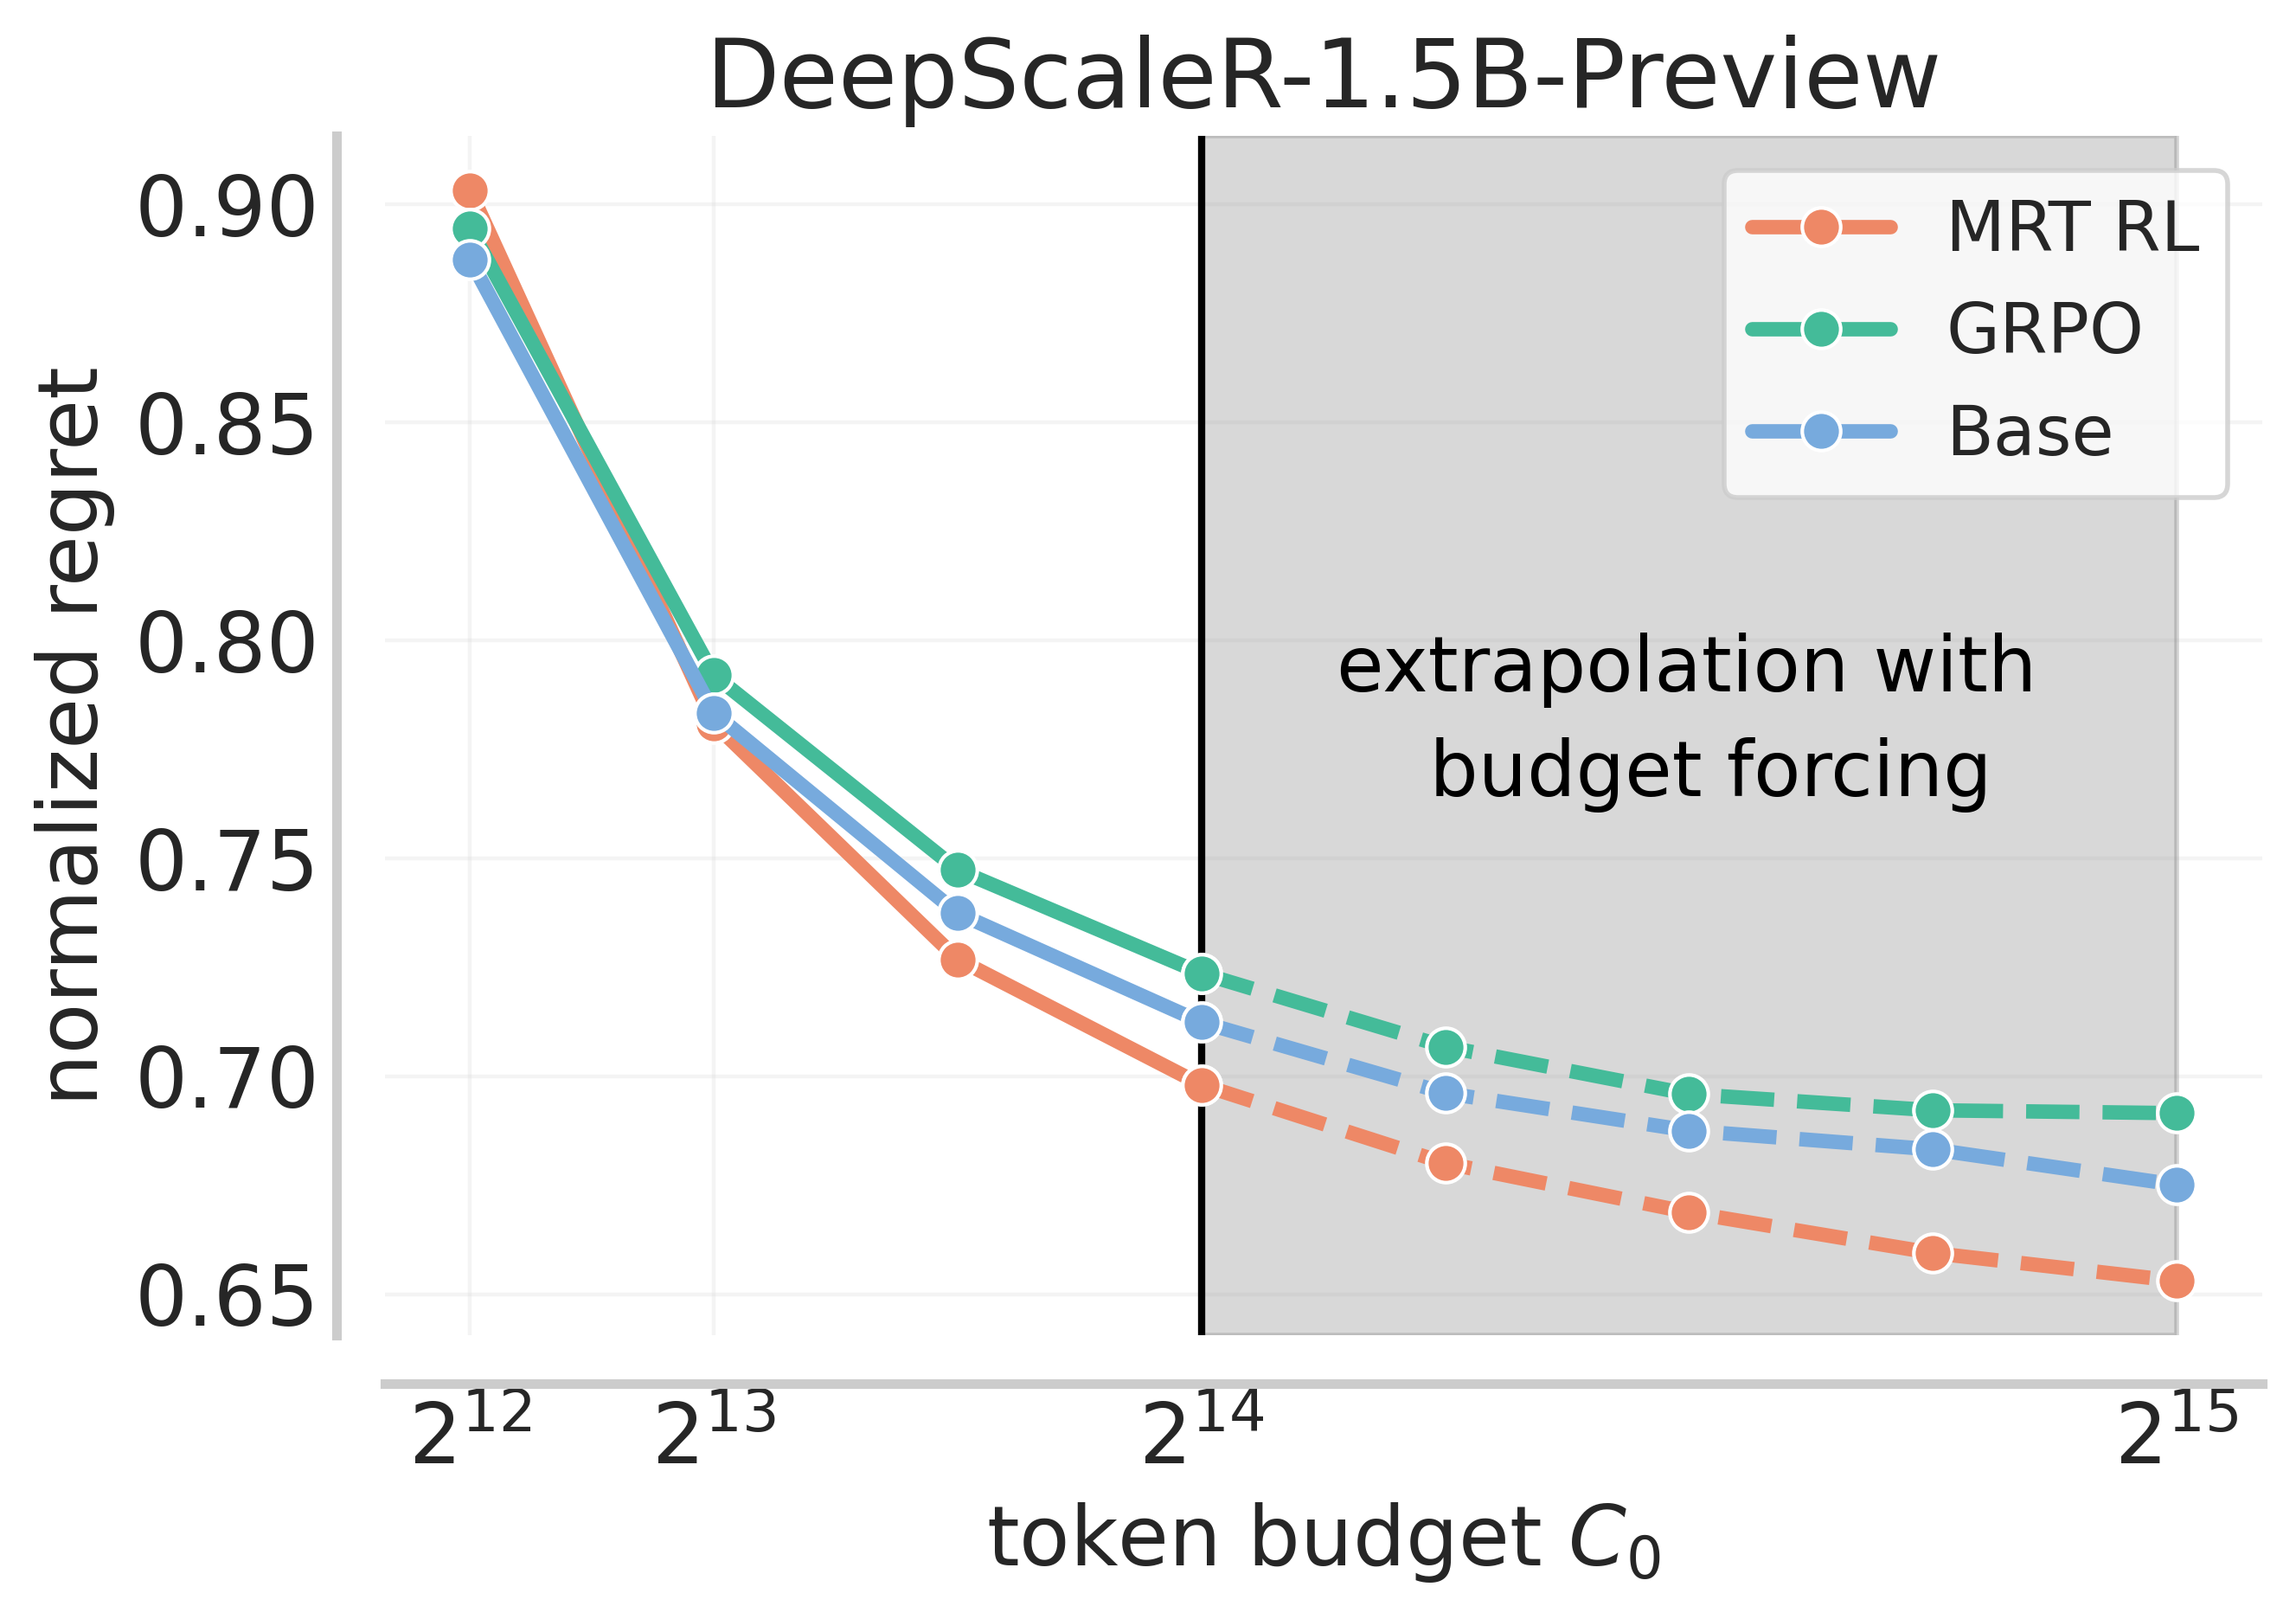

In [11]:
fig, ax = plt.subplots(figsize=(14 / 2, 4.5), dpi=400)
ax.axvline(16384, 0, 1, color='black')
ax.axvspan(16384, 32768, alpha=0.3, color='gray')
txt = ax.text(0.7, 0.45, "extrapolation with \n budget forcing", fontsize=16, color='black', ha='center', linespacing=1.5, transform=ax.transAxes)

# normal results
sns.lineplot(x=[4096, 8192, 12288, 16384], y=1 - np.array(folder_to_areas["mrt"][:4]), label="MRT RL", marker='o', ax=ax, linewidth=3, markersize=8, color=COLORS[4])
sns.lineplot(x=[4096, 8192, 12288, 16384], y=1 - np.array(folder_to_areas["grpo"][:4]), label="GRPO", marker='o', ax=ax, linewidth=3, markersize=8, color=COLORS[2])
sns.lineplot(x=[4096, 8192, 12288, 16384], y=1 - np.array(folder_to_areas["base"][:4]), label="Base", marker='o', ax=ax, linewidth=3, markersize=8, color=COLORS[1])

# extrapolation
sns.lineplot(x=[16384, 20480, 24576, 28672, 32768], y=1 - np.array(folder_to_areas["mrt"][3:]), marker='o', ax=ax, linewidth=3, markersize=8, color=COLORS[4], linestyle='--')
sns.lineplot(x=[16384, 20480, 24576, 28672, 32768], y=1 - np.array(folder_to_areas["grpo"][3:]), marker='o', ax=ax, linewidth=3, markersize=8, color=COLORS[2], linestyle='--')
sns.lineplot(x=[16384, 20480, 24576, 28672, 32768], y=1 - np.array(folder_to_areas["base"][3:]), marker='o', ax=ax, linewidth=3, markersize=8, color=COLORS[1], linestyle='--')

plt.xticks(ticks=[2 ** i for i in range(12, 16)], labels=[f"$2^{{{i}}}$" for i in range(12, 16)])

plt.rcParams["legend.loc"] = "upper right"

plot_utils._annotate_and_decorate_axis(ax,
                                        xlabel='token budget $C_0$',
                                        ylabel='normalized regret',
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)
ax.set_title("DeepScaleR-1.5B-Preview", fontsize=20)
plt.show()